In [1]:
from env_interface import make_env, make_model, train_model, load_model, run_model, visualize_obs
from callbacks import RolloutCheckCallback
from datetime import datetime
from stable_baselines3 import A2C, SAC, PPO
from stable_baselines3.common.policies import ActorCriticCnnPolicy
from stable_baselines3.sac.policies import CnnPolicy
%matplotlib inline

device = 'cuda'  # Doesn't work, it still trains on CPU

models_folder = "trained_models"
build_folder = "Builds_stable_baselines"
env_file = "C:/Users/sirir/Desktop/University/Master/Semester_3/Data_Science_Semester_Project/Unity_projects/RollerBall_Playground/{}/RollerBall_Playground".format(build_folder)

run_id = datetime.now().strftime("%d%m%Y_%H%M%S")  # Unique identifier for this training run
training_log_dir = "./{}/training_logs/{}/".format(models_folder, run_id)
eval_log_dir = "./{}/eval_logs/{}/".format(models_folder, run_id)
env_log_dir = "./{}/logs/{}/".format(models_folder, run_id)
model_dir = "./{}/models/{}/".format(models_folder, run_id)

callback = None  #RolloutCheckCallback()

common_init_params = {
    "tensorboard_log": training_log_dir,
    "device": device,
    "verbose": 1,
#    "use_sde": True,
#    "sde_sample_freq": 3,
}
common_train_params = {
    "callback": callback,
    "log_interval": 1000,
#    "progress_bar": True,  # Not recognized apparently
}

models = {
    "A2C": {
        "class": A2C,
        "policy": ActorCriticCnnPolicy,
        "init_params": {
            "learning_rate": 0.001,
            "n_steps" : 64,
            **common_init_params
        },
        "train_params": {
            "total_timesteps": 10000,
            **common_train_params
        }
    },
    "PPO": {
        "class": PPO,
        "policy": ActorCriticCnnPolicy,
        "init_params": {
            "learning_rate": 3.0e-4,
            "n_steps": 256,  # Is this the horizon in mlagents?
            "n_epochs": 3,
            "batch_size": 16,
            "gamma": 0.99,
            "ent_coef": 5.0e-3,
            "gae_lambda": 0.95,
            **common_init_params
        },
        "train_params": {
            "total_timesteps": 20000,
            **common_train_params
        }
    },
    "SAC": {
        "class": SAC,
        "policy": CnnPolicy,
        "init_params": {
            "learning_rate": 0.0001,
            **common_init_params
        },
        "train_params": {
            "total_timesteps": 10000,
            **common_train_params
        }
    },
    "PPO_test": {
        "class": PPO,
        "policy": ActorCriticCnnPolicy,
        "init_params": {
            "learning_rate": 0.01,
            "n_steps": 5,
            "n_epochs": 3,
            "batch_size": 16,
            **common_init_params
        },
        "train_params": {
            "total_timesteps": 150,
            **common_train_params
        }
    }
}

In [2]:
model_params = models["PPO"]

env = make_env(env_file, env_log_dir, no_graphics=False)
try:
    model = make_model(env, model_params["class"], model_params["policy"], model_params["init_params"])
    train_model(model, env, model_params["train_params"], model_dir, eval_log_dir, episodes=-1)
finally:
    env.close()

INFO:mlagents_envs:Connected new brain:
RollerBallBrain?team=0
INFO:gym_unity:1 agents within environment.
c:\Users\sirir\anaconda3\envs\dsproject\lib\site-packages\gym\spaces\box.py:74: UserWarning: WARN: Box bound precision lowered by casting to float32
  "Box bound precision lowered by casting to {}".format(self.dtype)


Using cpu device
Wrapping the env in a DummyVecEnv.
Wrapping the env in a VecTransposeImage.
Logging to ./trained_models/training_logs/28112022_153332/PPO_1


INFO:mlagents_envs:Environment shut down with return code 0 (CTRL_C_EVENT).


In [3]:
env = make_env(env_file, env_log_dir, no_graphics=False)  # Visualise result
try:
    env.reset()
    model = load_model(model_dir, env, model_params["class"])
    run_model(env, model, n_steps=300)
finally:
    env.close()

INFO:mlagents_envs:Connected new brain:
RollerBallBrain?team=0
INFO:gym_unity:1 agents within environment.
c:\Users\sirir\anaconda3\envs\dsproject\lib\site-packages\gym\spaces\box.py:74: UserWarning: WARN: Box bound precision lowered by casting to float32
  "Box bound precision lowered by casting to {}".format(self.dtype)


Wrapping the env in a DummyVecEnv.
Wrapping the env in a VecTransposeImage.


INFO:mlagents_envs:Environment shut down with return code 0 (CTRL_C_EVENT).


In [6]:
import tensorflow as tf
import datetime, os
%load_ext tensorboard

#print(training_log_dir)

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [8]:
%tensorboard --logdir ./trained_models/training_logs/28112022_153332/

Reusing TensorBoard on port 6006 (pid 5340), started 0:11:40 ago. (Use '!kill 5340' to kill it.)

# Sandbox

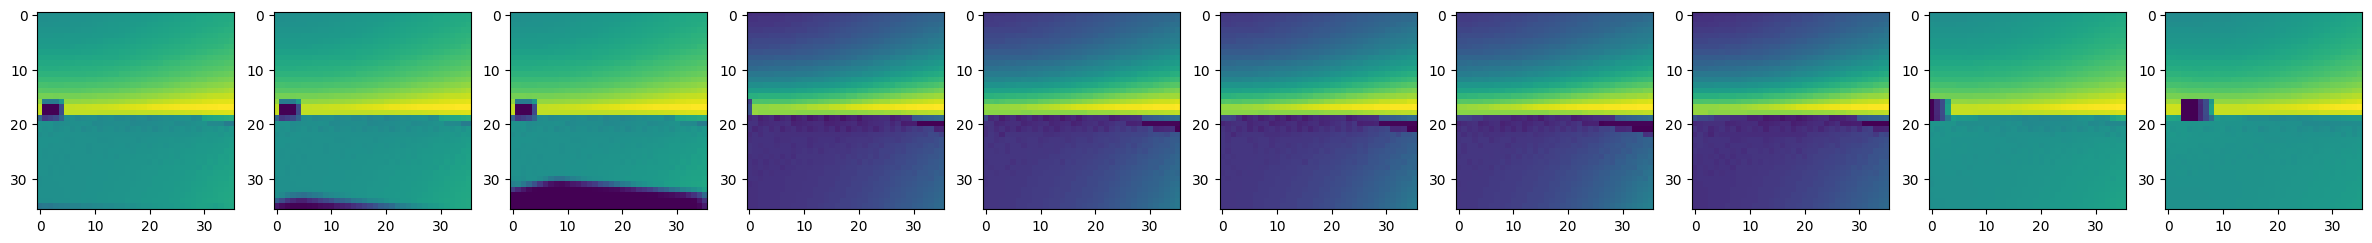

In [5]:
#import numpy as np
#import matplotlib.pyplot as plt
'''print(np.min(callback.rewards), np.max(callback.rewards))
for reward in np.concatenate(callback.rewards)[np.concatenate(callback.dones)]:  # The rewards obtained when the agent is done is always -0.01! That's wrong but how come this happens??
    print(reward)'''
#callback.rollout_buffers[callback.dones]
'''print(callback.total_timesteps_of_model)
print(callback.n_steps_of_model)
print(callback.n_rollout_steps)
print(callback.n_steps_vals_at_rollout_end)
print(callback.num_timesteps_at_training_start)
print(callback.num_timesteps_at_training_end)
fig, ax = plt.subplots(figsize=(16, 4), ncols=4)
ax[0].plot(callback.obs_min)
ax[0].set_title("Min value of observation")
ax[1].plot(callback.obs_max)
ax[1].set_title("Max value of observation")
ax[2].plot(callback.rewards)
ax[2].set_title("Reward obtained")
ax[3].scatter(np.concatenate(callback.actions)[:, 0], np.concatenate(callback.actions)[:, 1], label="Actions")
ax[3].scatter(np.concatenate(callback.clipped_actions)[:, 0], np.concatenate(callback.clipped_actions)[:, 1], label="Clipped actions")
ax[3].legend()
ax[3].set_title("Actions and clipped actions")

plt.show()'''

'''n_obs = len(callback.obs[:10])
fig, ax = plt.subplots(figsize=(3*n_obs, 3), ncols=n_obs)
for i, obs in enumerate(callback.obs[:10]):
    ax.item(i).imshow(obs[0, 0])
plt.show()'''